In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pydicom
from skimage import io
from itertools import chain


EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [2]:
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
89961,00022343_000.png,No Finding,0,22343,24,M,PA,3056,2544,0.139,0.139,NaN
5958,00001606_005.png,No Finding,5,1606,44,F,PA,2578,2991,0.143,0.143,NaN
104136,00027809_005.png,No Finding,5,27809,41,F,AP,3056,2544,0.139,0.139,NaN


## Exploratory Data Analysis (EDA)

### 1. Labels distribution on the data

In [3]:
# 1st we will split labels by the | symbol separator.
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
print(f'We have {len(all_labels)} unique labels and they are: {all_labels}')

We have 15 unique labels and they are: ['Atelectasis' 'Cardiomegaly' 'Consolidation' 'Edema' 'Effusion'
 'Emphysema' 'Fibrosis' 'Hernia' 'Infiltration' 'Mass' 'No Finding'
 'Nodule' 'Pleural_Thickening' 'Pneumonia' 'Pneumothorax']


In [4]:
i = 2
for label in all_labels:
    # lets create a column based on each disease and set to 1 if the patient has it.
    all_xray_df.insert(i, label, all_xray_df['Finding Labels'].map(lambda str_label: 1.0 if label in str_label else 0))
    #all_xray_df[label] = all_xray_df['Finding Labels'].map(lambda str_label: 1.0 if label in str_label else 0)
    i=i+1

In [5]:
pd.set_option('display.max_columns', None) #if set to None the dataframe displays all columns.
all_xray_df.sample(3)

,Image Index,Finding Labels,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
25800,00006782_000.png,Atelectasis|Infiltration,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,6782,53,M,AP,2500,2048,0.171,0.171,NaN
73332,00018044_039.png,Cardiomegaly|Effusion|Fibrosis,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39,18044,34,F,AP,2048,2500,0.168,0.168,NaN
80776,00019857_001.png,No Finding,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,19857,30,F,PA,2992,2991,0.143,0.143,NaN


In [6]:
all_xray_df.sample(3).iloc[:, :17]

,Image Index,Finding Labels,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
11568,00003028_071.png,Atelectasis|Emphysema|Infiltration|Pneumothorax,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
12250,00003190_020.png,No Finding,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
103584,00027648_015.png,No Finding,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


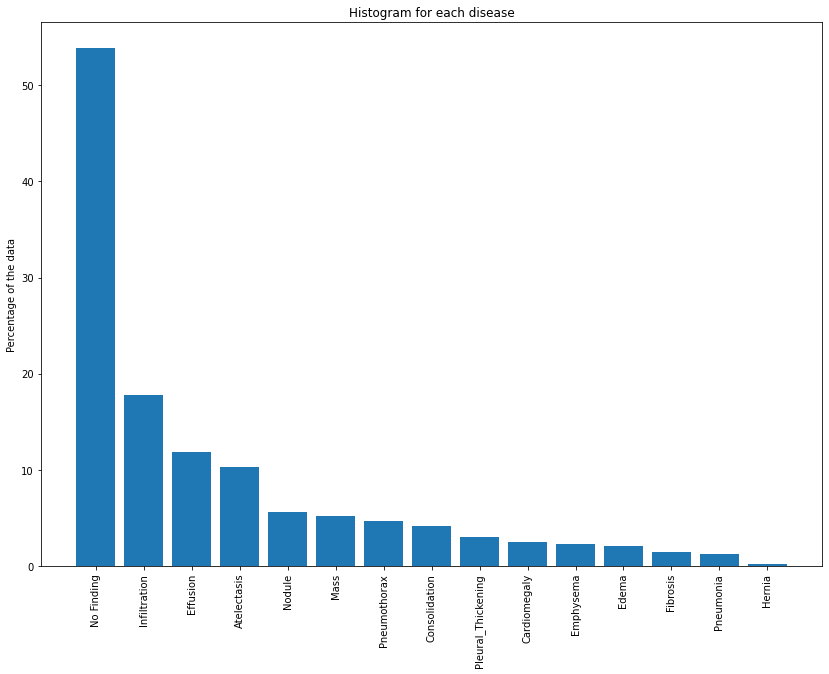

In [7]:
labels = all_xray_df[all_labels].sum().sort_values(ascending=False).index
values = all_xray_df[all_labels].sum().sort_values(ascending=False).values/len(all_xray_df)*100
plt.figure(figsize=(14,10))
plt.bar(labels, values)
plt.ylabel('Percentage of the data')
plt.xticks(rotation='vertical')
plt.title('Histogram for each disease')
plt.show()

As expected, most of the analysis done to patients results in no finding of a disease. However, the most frequent diseases in this dataset are `infiltration`, `effusion`, and `atelectasis`. Therefore we will proceed to see their relation to other diseases below:

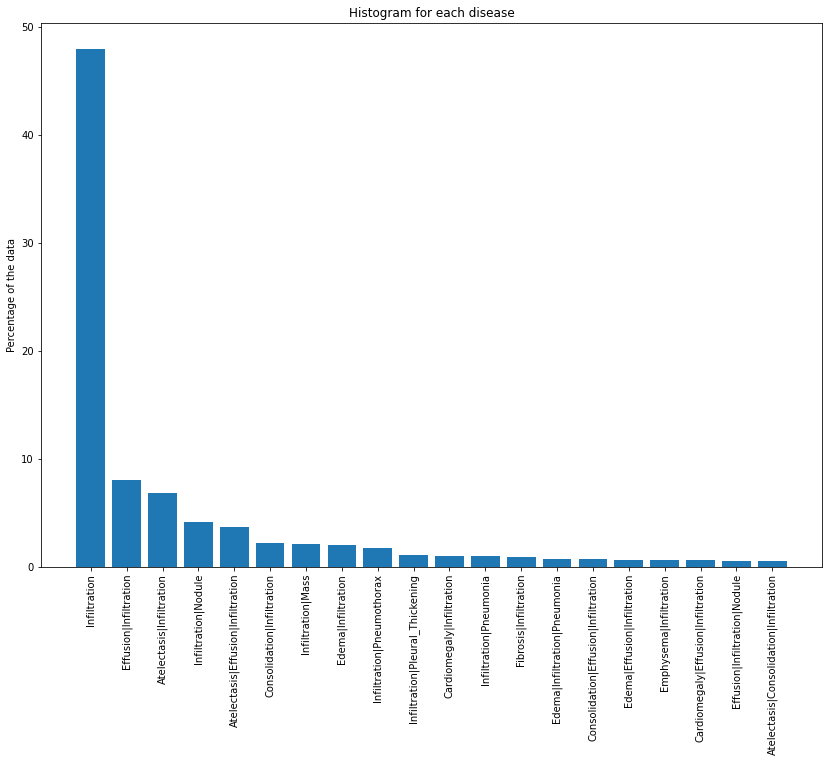

In [8]:
# Infiltration
Assessing = 'Infiltration'
x = all_xray_df[all_xray_df[Assessing]==1]['Finding Labels'].value_counts()[0:20].index
y = all_xray_df[all_xray_df[Assessing]==1]['Finding Labels'].value_counts()[0:20].values/len(all_xray_df[
    all_xray_df[Assessing]==1]['Finding Labels'])*100
plt.figure(figsize=(14,10))
plt.bar(x, y)
plt.ylabel('Percentage of the data')
plt.xticks(rotation='vertical')
plt.title('Histogram for each disease')
plt.show()

As shown above, we can infer that most of the infiltration disease occurs alone with no relation to other diseases, at least in this dataset, with almost 50% of all infiltration cases presented in it. However, Effusion and Atelectasis are its most frequent comorbidities.

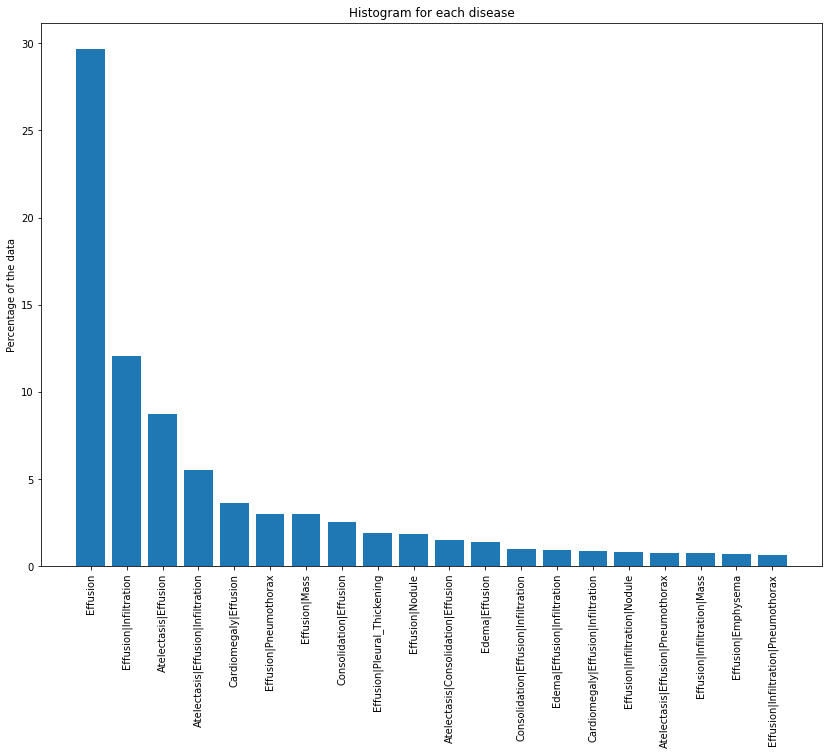

In [9]:
# Effusion
Assessing = 'Effusion'
x = all_xray_df[all_xray_df[Assessing]==1]['Finding Labels'].value_counts()[0:20].index
y = all_xray_df[all_xray_df[Assessing]==1]['Finding Labels'].value_counts()[0:20].values/len(all_xray_df[
    all_xray_df[Assessing]==1]['Finding Labels'])*100
plt.figure(figsize=(14,10))
plt.bar(x, y)
plt.ylabel('Percentage of the data')
plt.xticks(rotation='vertical')
plt.title('Histogram for each disease')
plt.show()

As shown above, we can infer that most of the Effusion disease occurs alone with no relation to other diseases, at least in this dataset, with almost 30% of all Effusion cases presented in it. However, Infiltration and Atelectasis are its most frequent comorbidities, which represent 12.5% and 8.5% respectively for this dataset.


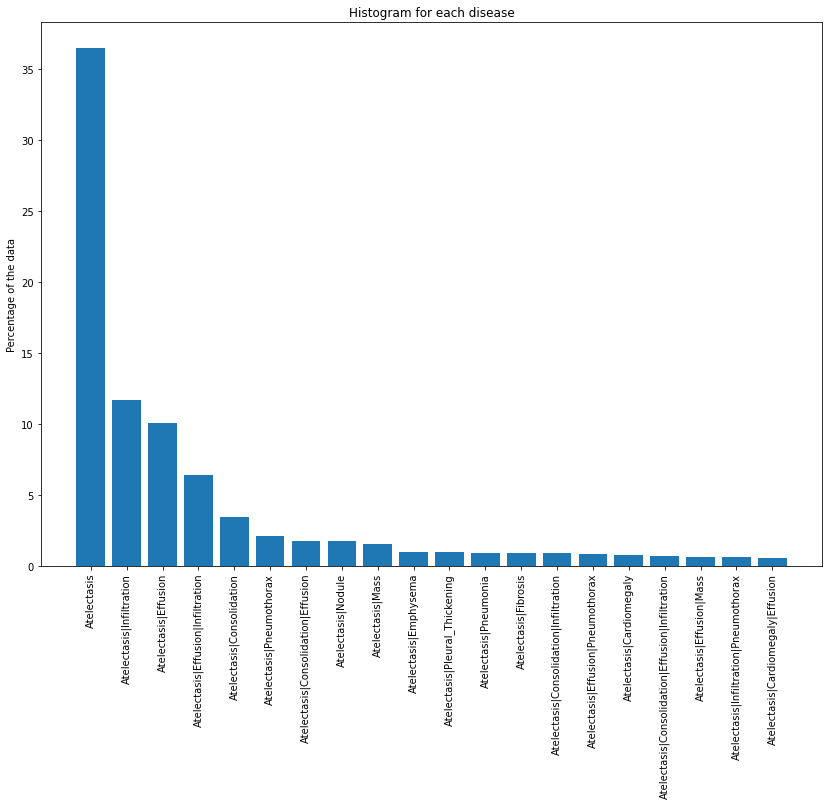

In [10]:
# Atelectasis
Assessing = 'Atelectasis'
x = all_xray_df[all_xray_df[Assessing]==1]['Finding Labels'].value_counts()[0:20].index
y = all_xray_df[all_xray_df[Assessing]==1]['Finding Labels'].value_counts()[0:20].values/len(all_xray_df[
    all_xray_df[Assessing]==1]['Finding Labels'])*100
plt.figure(figsize=(14,10))
plt.bar(x, y)
plt.ylabel('Percentage of the data')
plt.xticks(rotation='vertical')
plt.title('Histogram for each disease')
plt.show()

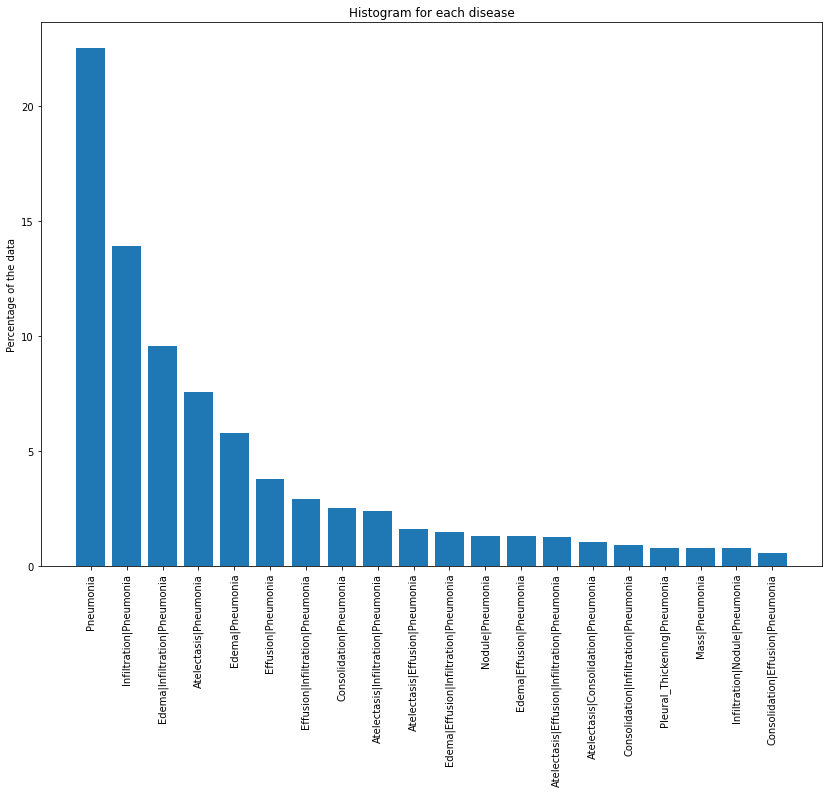

In [11]:
# Pneumonia
Assessing = 'Pneumonia'
x = all_xray_df[all_xray_df[Assessing]==1]['Finding Labels'].value_counts()[0:20].index
y = all_xray_df[all_xray_df[Assessing]==1]['Finding Labels'].value_counts()[0:20].values/len(all_xray_df[
    all_xray_df[Assessing]==1]['Finding Labels'])*100
plt.figure(figsize=(14,10))
plt.bar(x, y)
plt.ylabel('Percentage of the data')
plt.xticks(rotation='vertical')
plt.title('Histogram for each disease')
plt.show()

As shown above, we can infer that most of the Atelectasis disease occurs alone with no relation to other diseases, at least in this dataset, with around 35% of all Atelectasis cases presented in it. However, Infiltration and Effusion are its most frequent comorbidities, which represent 12.5% and 10% respectively.

**Conclusion:** we can say that for this dataset the most frequent diseases are `infiltration`, `effusion`, and `atelectasis` and in most cases, they are independent of other diseases. However, the most related diseases or comorbidities are among themselves. In other words:

* For `Infiltratation` its top 2 comorbidities are `effusion` and `atelectasis`
* For `Effusion` its top 2 comorbidities are `Infiltratation` and `atelectasis` 
* For `Atelectasis` its top 2 comorbidities are `Infiltratation` and `effusion` 
* For `Pneumonia` its top 4 comorbities are `Infiltration`, `Edema`, `Atelectasis` and `Effusion`

## 2. Basic demographics 
### 2.1 View Position

For the position in which the studies were taken we only have two cases PA and AP, that can be best illustrated by the figure below:
<img src='https://medicforyou.in/wp-content/uploads/2015/09/AP-vs-PA-view-of-Chest-Xray.jpg' width=600px>

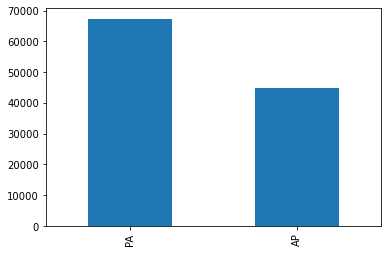

In [12]:
all_xray_df.drop(all_labels, axis=1)['View Position'].value_counts().plot(kind='bar');

From the image above, we can see that from all data most was taken in the PA view position. Now, let's see if that affects the three diseases we assessed in the previous section.  

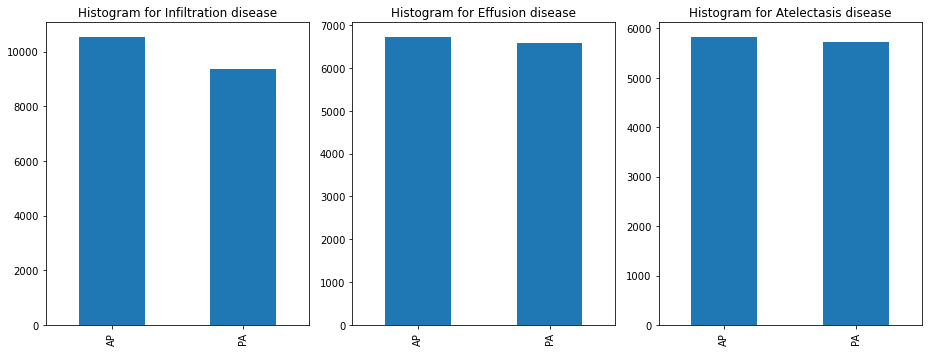

In [13]:
# Visualizing data for the three main diseases
fig = plt.figure(figsize=(13,5))
ax = fig.add_subplot(1,3,1)
all_xray_df[all_xray_df['Infiltration']==1]['View Position'].value_counts().plot(kind='bar');
plt.title('Histogram for Infiltration disease')
ax = fig.add_subplot(1,3,2)
all_xray_df[all_xray_df['Effusion']==1]['View Position'].value_counts().plot(kind='bar');
plt.title('Histogram for Effusion disease')
ax = fig.add_subplot(1,3,3)
all_xray_df[all_xray_df['Atelectasis']==1]['View Position'].value_counts().plot(kind='bar');
plt.title('Histogram for Atelectasis disease')
fig.tight_layout()

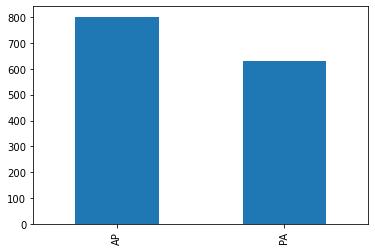

In [14]:
# Pneumonia
all_xray_df[all_xray_df['Pneumonia']==1]['View Position'].value_counts().plot(kind='bar');

**Conclusion:** From the histograms above we can say that view position does not affect the occurance of the disease since we have almost a balanced view postion cases for each disease

### 2.2 Patient Age

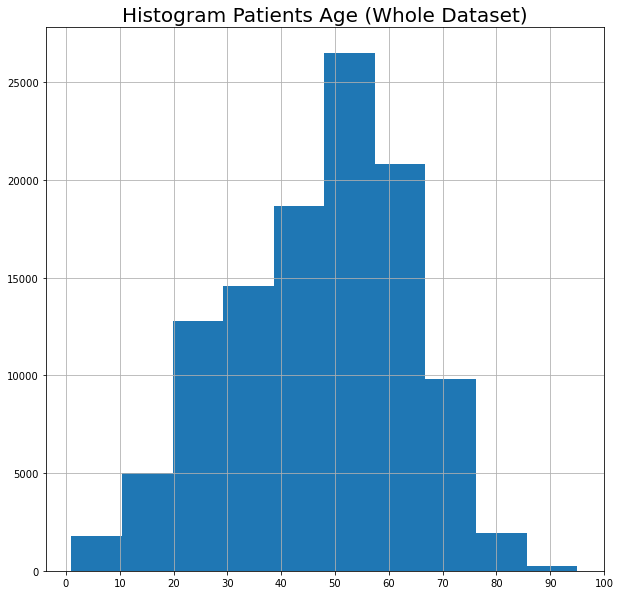

In [15]:
plt.figure(figsize=(10,10))
all_xray_df[all_xray_df['Patient Age']<100]['Patient Age'].hist(bins=10);
plt.xticks(list(range(0,101,10)));
plt.title('Histogram Patients Age (Whole Dataset)', fontsize=20)
plt.show()

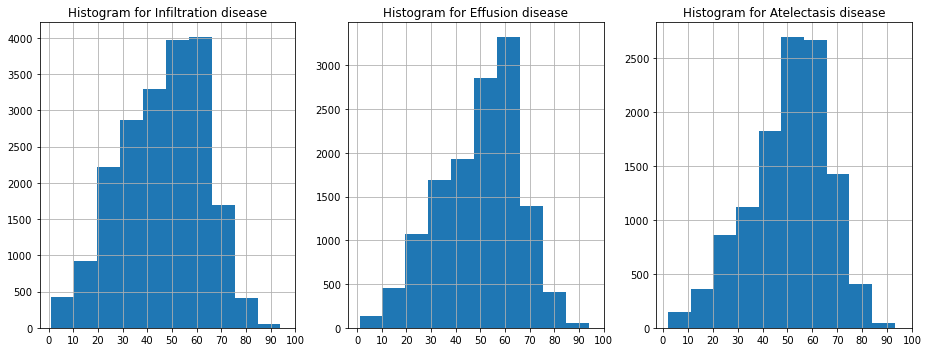

In [16]:
# Visualizing data for the three main diseases
fig = plt.figure(figsize=(13,5))
ax = fig.add_subplot(1,3,1)
all_xray_df[(all_xray_df['Patient Age']<100) & (all_xray_df['Infiltration']==1)]['Patient Age'].hist(bins=10);
plt.title('Histogram for Infiltration disease')
plt.xticks(list(range(0,101,10)));
ax = fig.add_subplot(1,3,2)
all_xray_df[(all_xray_df['Patient Age']<100) & (all_xray_df['Effusion']==1)]['Patient Age'].hist(bins=10);
plt.title('Histogram for Effusion disease')
plt.xticks(list(range(0,101,10)));
ax = fig.add_subplot(1,3,3)
all_xray_df[(all_xray_df['Patient Age']<100) & (all_xray_df['Atelectasis']==1)]['Patient Age'].hist(bins=10);
plt.title('Histogram for Atelectasis disease')
plt.xticks(list(range(0,101,10)));
fig.tight_layout()

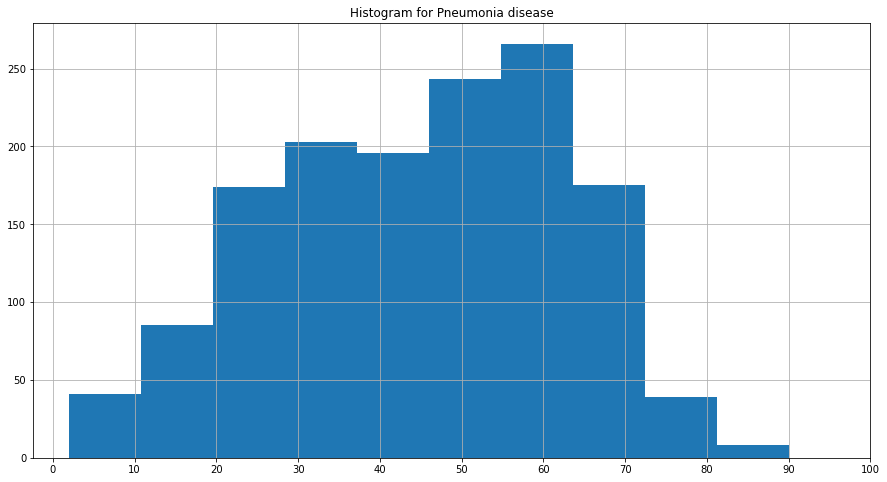

In [36]:
# Pneumonia
plt.figure(figsize=(15,8))
all_xray_df[(all_xray_df['Patient Age']<100) & (all_xray_df['Pneumonia']==1)]['Patient Age'].hist(bins=10);
plt.title('Histogram for Pneumonia disease')
plt.xticks(list(range(0,101,10)));

**Conclusion:** From histograms above we can say that `Infiltration` disesase is more skewed towards younger patients, whereas `Effusion` and `Atelectasis` have a more normal-like distribution with peaks around [56,65] and [48,65], respectively

### 2.3 Patient Gender

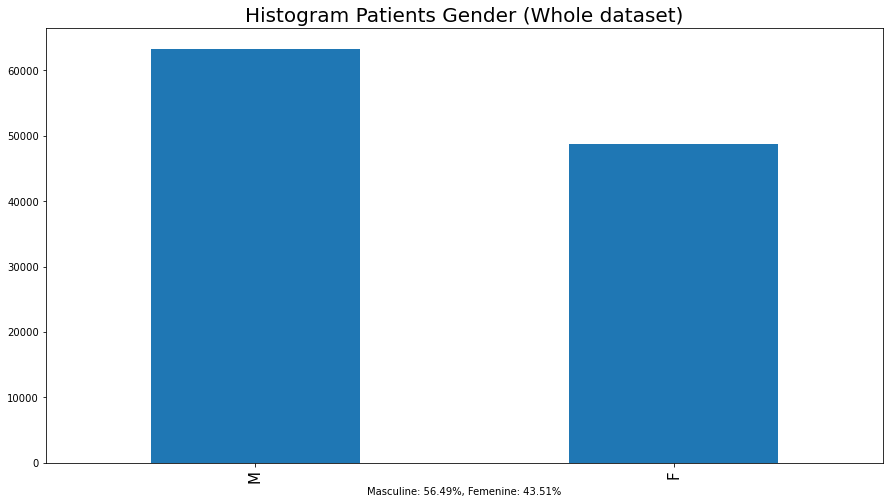

In [18]:
plt.figure(figsize=(15,8))
all_xray_df['Patient Gender'].value_counts().plot(kind='bar')
plt.xticks(fontsize=15)
m = all_xray_df['Patient Gender'].value_counts()[0]
f = all_xray_df['Patient Gender'].value_counts()[1]
plt.xlabel(f'Masculine: {m/(m+f)*100:.2f}%, Femenine: {f/(m+f)*100:.2f}%')
plt.title('Histogram Patients Gender (Whole dataset)', fontsize=20)
plt.show()

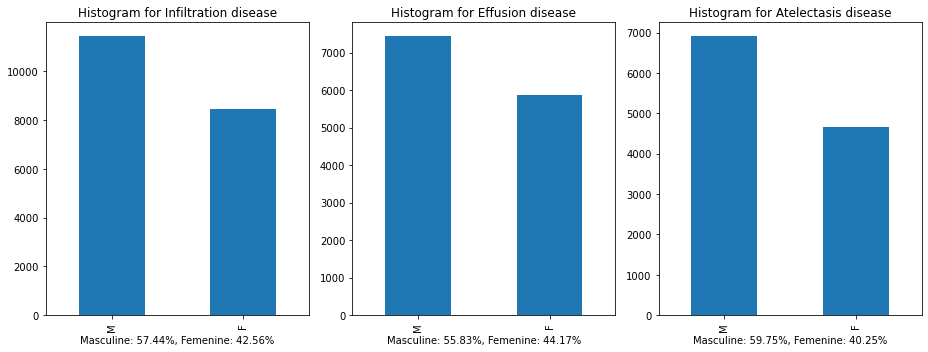

In [19]:
# Visualizing data for the three main diseases
fig = plt.figure(figsize=(13,5))
ax = fig.add_subplot(1,3,1)
all_xray_df[all_xray_df['Infiltration']==1]['Patient Gender'].value_counts().plot(kind='bar')
plt.title('Histogram for Infiltration disease')
m = all_xray_df[all_xray_df['Infiltration']==1]['Patient Gender'].value_counts()[0]
f = all_xray_df[all_xray_df['Infiltration']==1]['Patient Gender'].value_counts()[1]
plt.xlabel(f'Masculine: {m/(m+f)*100:.2f}%, Femenine: {f/(m+f)*100:.2f}%')
plt.xticks(fontsize=10)
ax = fig.add_subplot(1,3,2)
all_xray_df[all_xray_df['Effusion']==1]['Patient Gender'].value_counts().plot(kind='bar')
plt.title('Histogram for Effusion disease')
m = all_xray_df[all_xray_df['Effusion']==1]['Patient Gender'].value_counts()[0]
f = all_xray_df[all_xray_df['Effusion']==1]['Patient Gender'].value_counts()[1]
plt.xlabel(f'Masculine: {m/(m+f)*100:.2f}%, Femenine: {f/(m+f)*100:.2f}%')
plt.xticks(fontsize=10)
ax = fig.add_subplot(1,3,3)
all_xray_df[all_xray_df['Atelectasis']==1]['Patient Gender'].value_counts().plot(kind='bar')
plt.title('Histogram for Atelectasis disease')
m = all_xray_df[all_xray_df['Atelectasis']==1]['Patient Gender'].value_counts()[0]
f = all_xray_df[all_xray_df['Atelectasis']==1]['Patient Gender'].value_counts()[1]
plt.xlabel(f'Masculine: {m/(m+f)*100:.2f}%, Femenine: {f/(m+f)*100:.2f}%')
plt.xticks(fontsize=10)
fig.tight_layout()

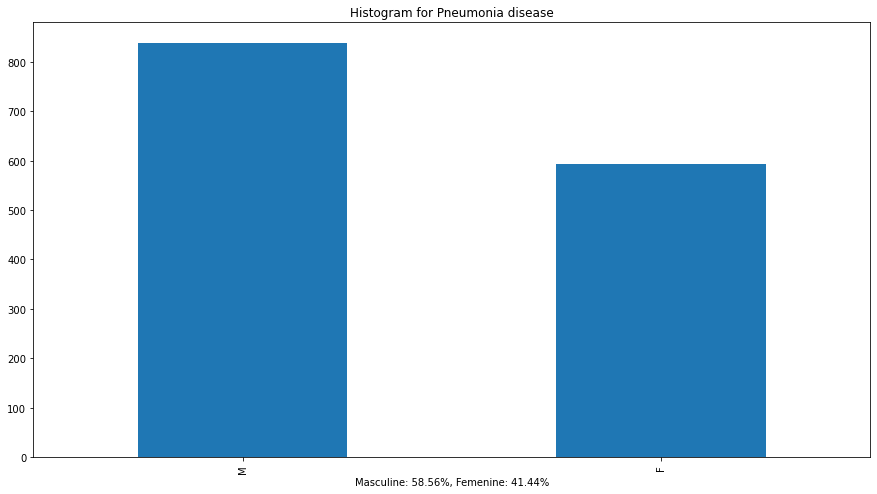

In [37]:
# Pneumonia
plt.figure(figsize=(15,8))
all_xray_df[all_xray_df['Pneumonia']==1]['Patient Gender'].value_counts().plot(kind='bar')
plt.title('Histogram for Pneumonia disease')
m = all_xray_df[all_xray_df['Pneumonia']==1]['Patient Gender'].value_counts()[0]
f = all_xray_df[all_xray_df['Pneumonia']==1]['Patient Gender'].value_counts()[1]
plt.xlabel(f'Masculine: {m/(m+f)*100:.2f}%, Femenine: {f/(m+f)*100:.2f}%')
plt.xticks(fontsize=10);

**Conclusion:** we can say that for all the diseases the prevalence of gender is `masculine` with a ratio closed to 60/40%. However, the whole population in the dataset tends to have the same ratio which could indicate that there are just more test cases of Masculine diseases rather than a tendency of masculine gender to acquire a certain disease.

## Pixel-level data Analysis

In [21]:
## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
225,00001249_002.png,Edema,2,1249,040Y,M,AP,2500,2048,0.168,0.168
5108,00027168_001.png,Atelectasis|Infiltration,1,27168,060Y,M,PA,2992,2991,0.143,0.143
1807,00009531_000.png,No Finding,0,9531,089Y,M,PA,2500,2048,0.168,0.168


In [22]:
# function to map images to image path location
all_image_paths = {os.path.basename(x): x for x in glob(os.path.join('/data/','images*/','images/', '*.png'))}
# Add images to a new column
#all_xray_df['Imgs_path'] = all_xray_df['Image Index'].map(all_image_paths.get)
sample_df['Imgs_path'] = sample_df['Image Index'].map(all_image_paths.get)

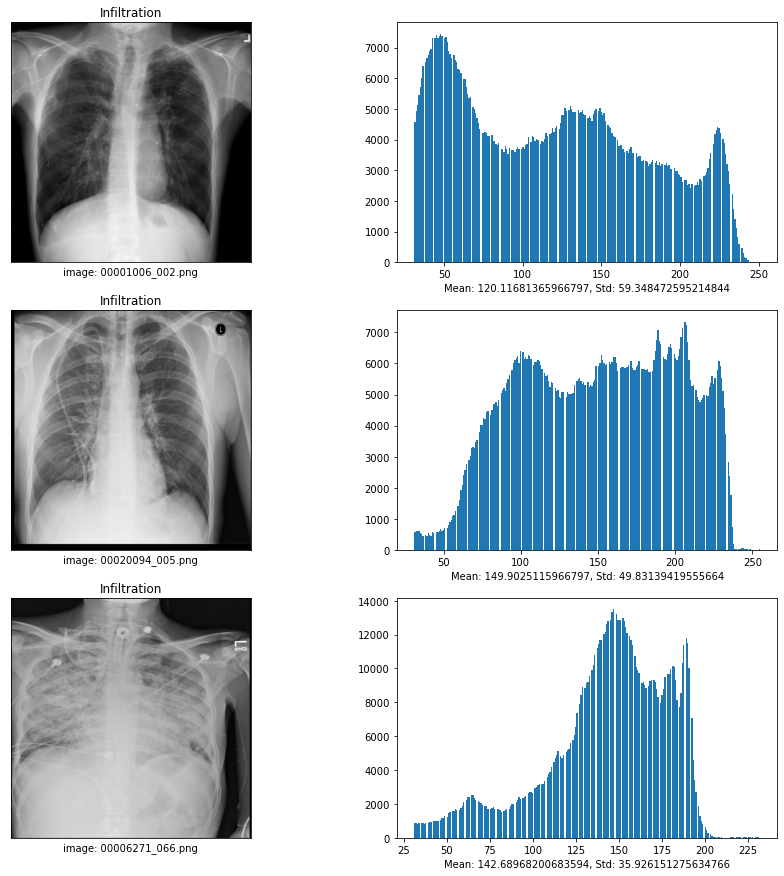

In [23]:
# Infiltration
assess = 'Infiltration'
no_samples = 3
cut_threshold = 30 # Value below this threshoold will be cut from the histogram to avoid peaks at zero values
#indexes = sample_df['Finding Labels'].str.contains(assess) # Uncomment in case you want to visualize comorbidities too
indexes = sample_df['Finding Labels']==assess

fig = plt.figure(figsize=(15,15))
temp_df = sample_df[indexes].sample(no_samples)
for i, (image_path, finding_label) in enumerate(zip(temp_df['Imgs_path'], temp_df['Finding Labels'])):
    ax = fig.add_subplot(no_samples,2,(i*2)+1)
    image = plt.imread(image_path)*255
    plt.imshow(image, cmap='gray')
    name_image = image_path.rsplit('/', 1)[1]
    plt.xlabel(f'image: {name_image}')
    plt.title(finding_label)
    plt.xticks([])
    plt.yticks([])
    ax = fig.add_subplot(no_samples,2,(i+1)*2)
    x = image[image>cut_threshold].ravel()
    plt.xlabel(f'Mean: {np.mean(x)}, Std: {np.std(x)}')
    plt.hist(x, bins=256)
    

**Comment:** Infiltration seems to have a peak around 150 and pixels are skewed to high pixels values. 

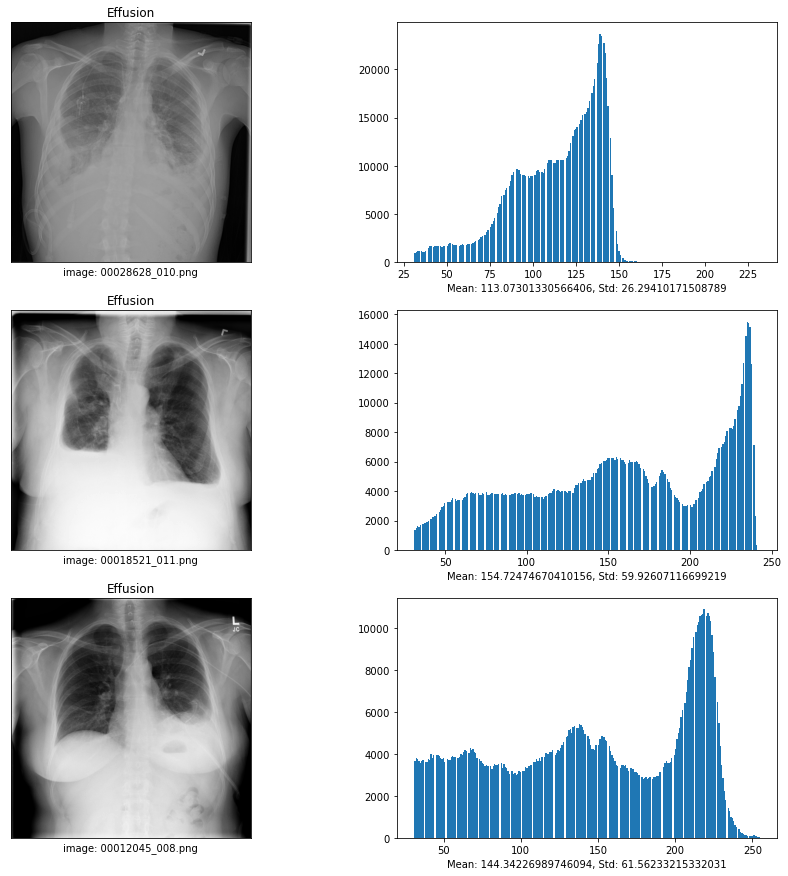

In [24]:
# Effusion
assess = 'Effusion'
no_samples = 3
cut_threshold = 30 # Value below this threshoold will be cut from the histogram to avoid peaks at zero values
#indexes = sample_df['Finding Labels'].str.contains(assess) # Uncomment in case you want to visualize comorbidities too
indexes = sample_df['Finding Labels']==assess

fig = plt.figure(figsize=(15,15))
temp_df = sample_df[indexes].sample(no_samples)
for i, (image_path, finding_label) in enumerate(zip(temp_df['Imgs_path'], temp_df['Finding Labels'])):
    ax = fig.add_subplot(no_samples,2,(i*2)+1)
    image = plt.imread(image_path)*255
    plt.imshow(image, cmap='gray')
    name_image = image_path.rsplit('/', 1)[1]
    plt.xlabel(f'image: {name_image}')
    plt.title(finding_label)
    plt.xticks([])
    plt.yticks([])
    ax = fig.add_subplot(no_samples,2,(i+1)*2)
    x = image[image>cut_threshold].ravel()
    plt.xlabel(f'Mean: {np.mean(x)}, Std: {np.std(x)}')
    plt.hist(x, bins=256)

**Comment:** Effusion seems to have a peak around 200-250 

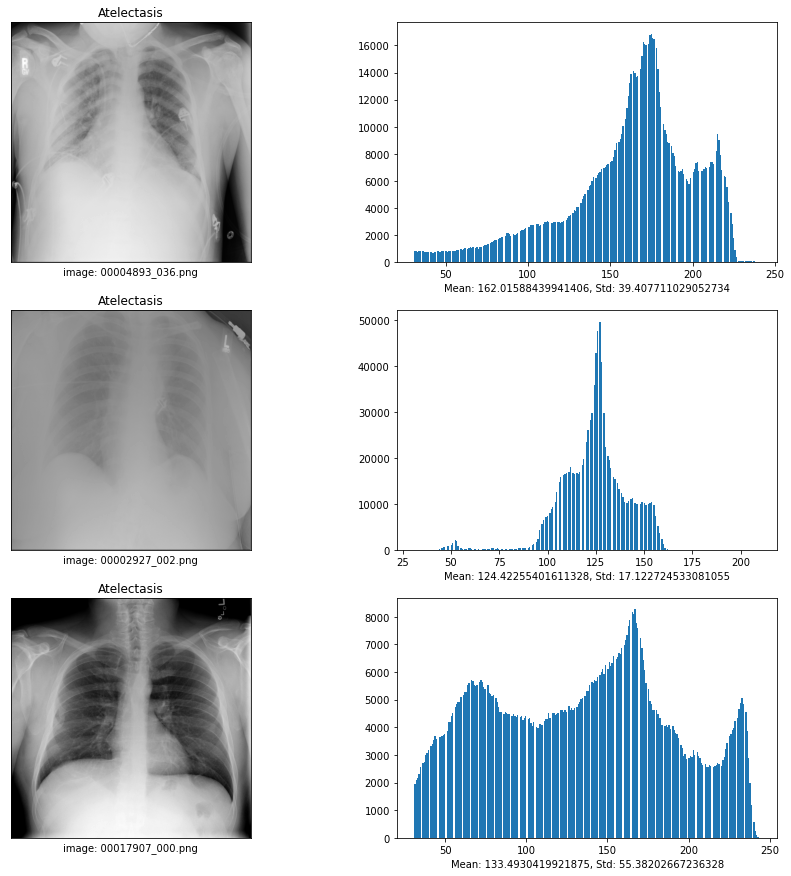

In [25]:
# Atelectasis
assess = 'Atelectasis'
no_samples = 3
cut_threshold = 30 # Value below this threshoold will be cut from the histogram to avoid peaks at zero values
#indexes = sample_df['Finding Labels'].str.contains(assess) # Uncomment in case you want to visualize comorbidities too
indexes = sample_df['Finding Labels']==assess

fig = plt.figure(figsize=(15,15))
temp_df = sample_df[indexes].sample(no_samples)
for i, (image_path, finding_label) in enumerate(zip(temp_df['Imgs_path'], temp_df['Finding Labels'])):
    ax = fig.add_subplot(no_samples,2,(i*2)+1)
    image = plt.imread(image_path)*255
    plt.imshow(image, cmap='gray')
    name_image = image_path.rsplit('/', 1)[1]
    plt.xlabel(f'image: {name_image}')
    plt.title(finding_label)
    plt.xticks([])
    plt.yticks([])
    ax = fig.add_subplot(no_samples,2,(i+1)*2)
    x = image[image>cut_threshold].ravel()
    plt.xlabel(f'Mean: {np.mean(x)}, Std: {np.std(x)}')
    plt.hist(x, bins=256)

**Comment:** Atelectasis seems to have a peak below 150

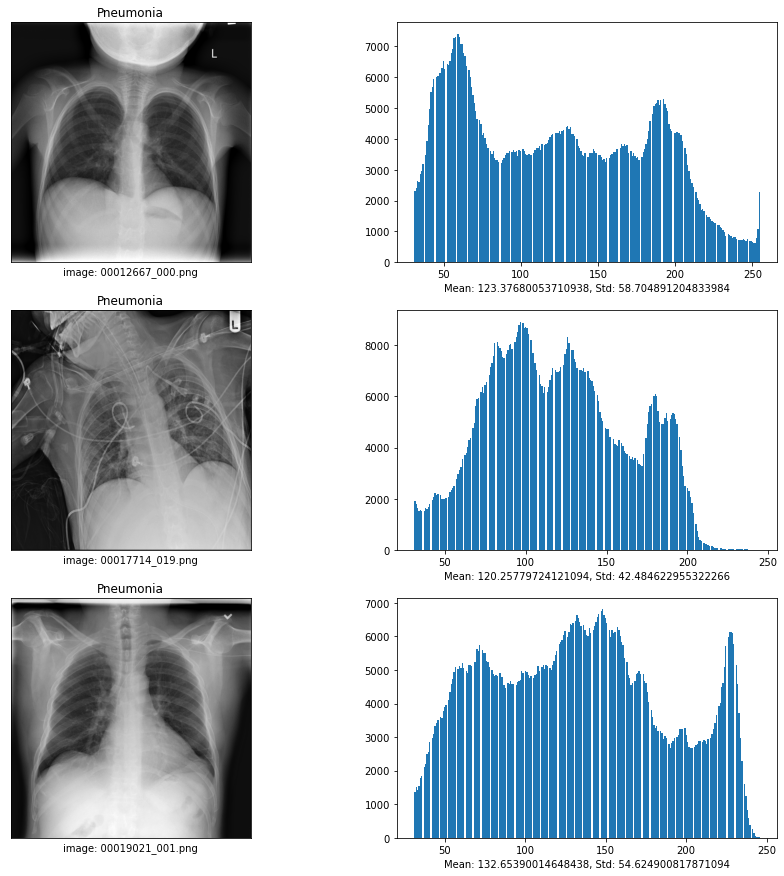

In [31]:
# Pneumonia
assess = 'Pneumonia'
no_samples = 3
cut_threshold = 30 # Value below this threshoold will be cut from the histogram to avoid peaks at zero values
#indexes = sample_df['Finding Labels'].str.contains(assess) # Uncomment in case you want to visualize comorbidities too
indexes = sample_df['Finding Labels']==assess

fig = plt.figure(figsize=(15,15))
temp_df = sample_df[indexes].sample(no_samples)
for i, (image_path, finding_label) in enumerate(zip(temp_df['Imgs_path'], temp_df['Finding Labels'])):
    ax = fig.add_subplot(no_samples,2,(i*2)+1)
    image = plt.imread(image_path)*255
    plt.imshow(image, cmap='gray')
    name_image = image_path.rsplit('/', 1)[1]
    plt.xlabel(f'image: {name_image}')
    plt.title(finding_label)
    plt.xticks([])
    plt.yticks([])
    ax = fig.add_subplot(no_samples,2,(i+1)*2)
    x = image[image>cut_threshold].ravel()
    plt.xlabel(f'Mean: {np.mean(x)}, Std: {np.std(x)}')
    plt.hist(x, bins=256)

**Comment:** Pneumonia tends to be skewed towards high-intensity pixels with a mean of around 145

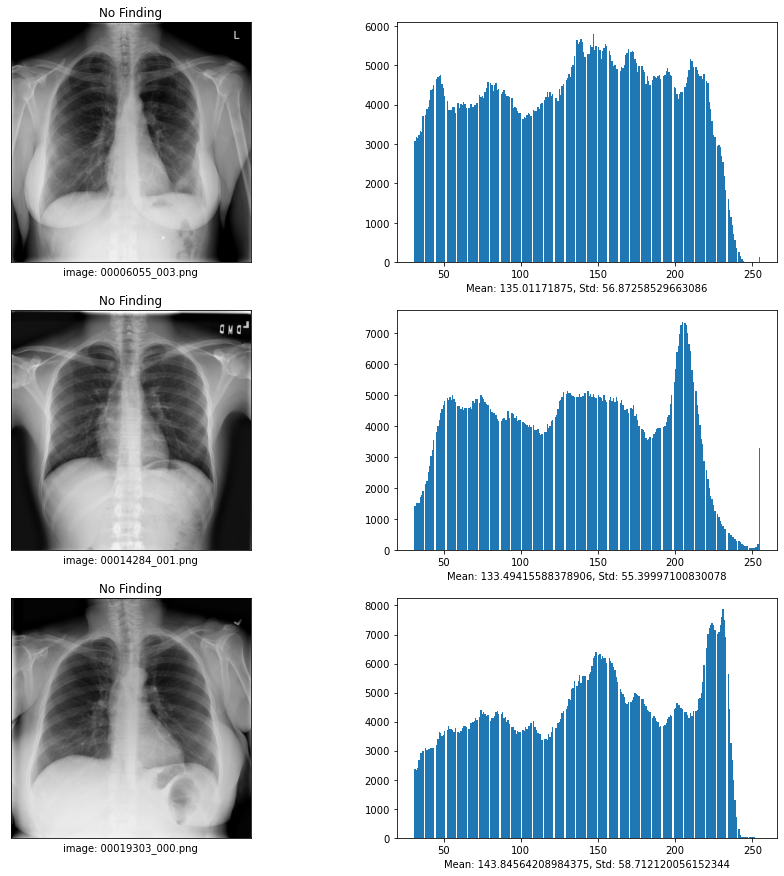

In [30]:
# Pneumonia
assess = 'No Finding'
no_samples = 3
cut_threshold = 30 # Value below this threshoold will be cut from the histogram to avoid peaks at zero values
#indexes = sample_df['Finding Labels'].str.contains(assess) # Uncomment in case you want to visualize comorbidities too
indexes = sample_df['Finding Labels']==assess

fig = plt.figure(figsize=(15,15))
temp_df = sample_df[indexes].sample(no_samples)
for i, (image_path, finding_label) in enumerate(zip(temp_df['Imgs_path'], temp_df['Finding Labels'])):
    ax = fig.add_subplot(no_samples,2,(i*2)+1)
    image = plt.imread(image_path)*255
    plt.imshow(image, cmap='gray')
    name_image = image_path.rsplit('/', 1)[1]
    plt.xlabel(f'image: {name_image}')
    plt.title(finding_label)
    plt.xticks([])
    plt.yticks([])
    ax = fig.add_subplot(no_samples,2,(i+1)*2)
    x = image[image>cut_threshold].ravel()
    plt.xlabel(f'Mean: {np.mean(x)}, Std: {np.std(x)}')
    plt.hist(x, bins=256)

## Pneumonia vs No Pneumonia comparison
**Conclusion:**  Based on intensity histograms for `No finding` and `Pneumonia` cases, we can say that images seem to have peals at lower intensity values while No findings at higher ones. The reason might be that presence of infiltration in lungs with `Pneumonia` have sort of a lower intensity tendency than `No Pneumonia` cases

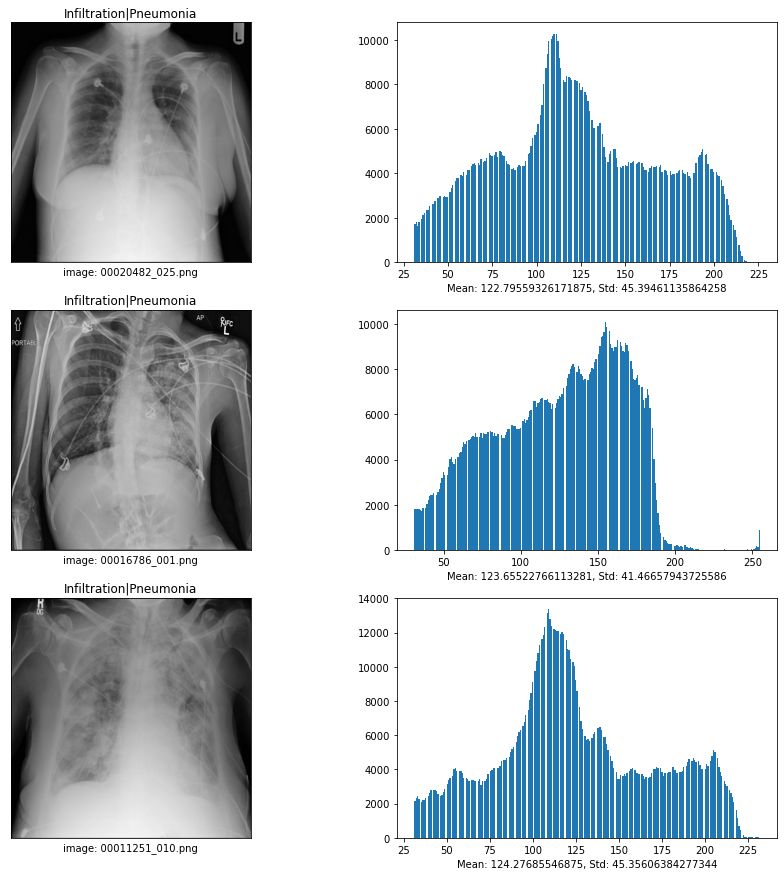

In [33]:
# Infiltration
assess = 'Infiltration|Pneumonia'
no_samples = 3
cut_threshold = 30 # Value below this threshoold will be cut from the histogram to avoid peaks at zero values
indexes = sample_df['Finding Labels'].eq(assess) # Uncomment in case you want to visualize comorbidities too
#indexes = sample_df['Finding Labels']==assess

fig = plt.figure(figsize=(15,15))
temp_df = sample_df[indexes].sample(no_samples)
for i, (image_path, finding_label) in enumerate(zip(temp_df['Imgs_path'], temp_df['Finding Labels'])):
    ax = fig.add_subplot(no_samples,2,(i*2)+1)
    image = plt.imread(image_path)*255
    plt.imshow(image, cmap='gray')
    name_image = image_path.rsplit('/', 1)[1]
    plt.xlabel(f'image: {name_image}')
    plt.title(finding_label)
    plt.xticks([])
    plt.yticks([])
    ax = fig.add_subplot(no_samples,2,(i+1)*2)
    x = image[image>cut_threshold].ravel()
    plt.xlabel(f'Mean: {np.mean(x)}, Std: {np.std(x)}')
    plt.hist(x, bins=256)

## Pneumonia vs Infiltration comparison
**Conclusion** Since Infiltration is very related to Pneumonia as seen in the histograms of comorbidities above, we will compare both of them as well. Based on intensity values we can conclude that infiltration intensity histograms have peaks at similar intensity levels. The reason could be that as Pneumonia thrives, the presence of infiltration is more a more notorious, therefore the peak is even more notorious in the same intensity values. This 2 diseases seem to be very related.

Besides the mean of infiltration tend to be very close to the Pneumonia cases.